In [1]:
import json
import torch
import transformers
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import random
import numpy as np

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax

In [12]:
import matplotlib.pyplot as plt

In [36]:
from scipy import stats

## 1. Inference incorporating knowledge with Bert

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).cuda()
model.eval()  # Ensure the model is in evaluation mode

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [9]:
def score_with_bert(tokenizer, model, context, knowledge, candidates, token_count=False, max_length=512):
    scores = []
    for cand in candidates:

        # Format input text as: [CLS] context [SEP] candidate [SEP]
        context = f"{context} {knowledge}" if knowledge is not None else context
        inputs = tokenizer.encode_plus(context, cand, max_length=max_length, truncation=True, return_tensors='pt', add_special_tokens=True).to(model.device)

        if token_count:
          # Print the number of tokens for debugging purposes
          num_tokens = inputs["input_ids"].size(1)
          print(f"Number of tokens for {cand} : {num_tokens}")
          if num_tokens > max_length:
            print("Max length exceeded")

        # Forward pass, get logits
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits.squeeze().item()  # Assuming binary classification

        # Store the logits as scores
        scores.append(logits)

    # Convert scores to probabilities
    probs = softmax(torch.tensor(scores), dim=0)
    return probs

def predict_with_bert(context, candidates, knowledge, token_count=False):
    probs = score_with_bert(tokenizer, model, context, knowledge, candidates, token_count=token_count)
    prediction = candidates[probs.argmax().item()]  # Choose the candidate with the highest probability
    return prediction, probs

In [6]:
with open("val_set.json") as f:
    ds = json.load(f)

with open("val_set_knowledge.json") as f:
    ds_know = json.load(f)

In [17]:
ds[0]

{'InputStoryid': '138d5bfb-05cc-41e3-bf2c-fa85ebad14e2',
 'cands': ['He is happy now.', 'He joined a gang.'],
 'answer': 'He is happy now.',
 'query': "Rick grew up in a troubled household. He never found good support in family, and turned to gangs. It wasn't long before Rick got shot in a robbery. The incident caused him to turn a new leaf."}

In [18]:
pbar = tqdm(ds)
num, den = 0, 0
correct_probs, incorrect_probs = [], []
probs_df = pd.DataFrame(columns=["ID", "correct_prob", "incorrect_prob"])
for item in pbar:

  # get item information
  story, candidates = item["query"], item["cands"]
  knowledge = None

  # predict
  item_prediction, item_probs = predict_with_bert(story, candidates, knowledge)

  # retrieve probabilities of outcomes
  if item_prediction == item["answer"]:
    num += 1
    correct_probs.append(item_probs.max().item())
    incorrect_probs.append(item_probs.min().item())
    probs_df.loc[len(probs_df)] = [item["InputStoryid"], item_probs.max().item(), item_probs.min().item()]
  else:
    correct_probs.append(item_probs.min().item())
    incorrect_probs.append(item_probs.max().item())
    probs_df.loc[len(probs_df)] = [item["InputStoryid"], item_probs.min().item(), item_probs.max().item()]

  # compute ongoing accuracy
  den += 1
  pbar.set_postfix({'acc': num / den})

100%|██████████| 1571/1571 [01:02<00:00, 24.95it/s, acc=0.414]


In [19]:
probs_df.to_csv("noknow.csv")

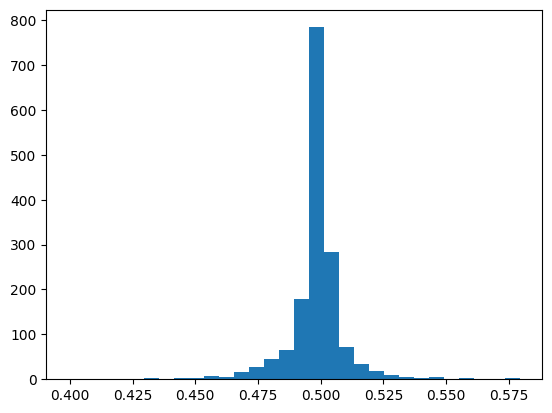

In [20]:
fig, ax = plt.subplots()
ax.hist(probs_df["correct_prob"], bins=30)
plt.show()

In [21]:
pbar = tqdm(ds_know)
num, den = 0, 0
correct_probs, incorrect_probs = [], []
probs_df = pd.DataFrame(columns=["ID", "correct_prob", "incorrect_prob"])
for item in pbar:

  # get item information
  story, candidates = item["query"], item["cands"]
  knowledge = item["knowledge"]

  # predict
  item_prediction, item_probs = predict_with_bert(story, candidates, knowledge)

  # retrieve probabilities of outcomes
  if item_prediction == item["answer"]:
    num += 1
    correct_probs.append(item_probs.max().item())
    incorrect_probs.append(item_probs.min().item())
    probs_df.loc[len(probs_df)] = [item["InputStoryid"], item_probs.max().item(), item_probs.min().item()]
  else:
    correct_probs.append(item_probs.min().item())
    incorrect_probs.append(item_probs.max().item())
    probs_df.loc[len(probs_df)] = [item["InputStoryid"], item_probs.min().item(), item_probs.max().item()]

  # compute ongoing accuracy
  den += 1
  pbar.set_postfix({'acc': num / den})

100%|██████████| 1571/1571 [00:53<00:00, 29.56it/s, acc=0.488]


## Hypothesis Test

In [26]:
probs_know_df = pd.read_csv("know.csv", index_col=0)
probs_nknow_df = pd.read_csv("noknow.csv", index_col=0)

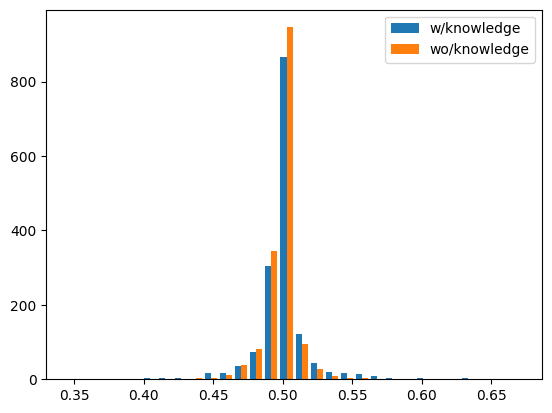

In [38]:
fig, ax = plt.subplots()
ax.hist([probs_know_df["correct_prob"], probs_nknow_df["correct_prob"]], bins=30)
ax.legend(["w/knowledge", "wo/knowledge"])
plt.show()

In [33]:
probs_know_df["correct_prob"].mean(), probs_know_df["correct_prob"].std()

(0.5007292449967562, 0.021113202364228326)

In [34]:
probs_nknow_df["correct_prob"].mean(), probs_nknow_df["correct_prob"].std()

(0.4984140470481693, 0.011494024230665416)

In [37]:
t_stat, p_val = stats.ttest_rel(probs_know_df["correct_prob"], probs_nknow_df["correct_prob"])
print("t stat", t_stat, "p value", p_val)

t stat 4.216445414871697 p value 2.623401972224445e-05
